In [97]:
import torch
import torchvision
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import zipfile

Let's define a model which would be trained for images in CIFAR10 dataset. Images have 3 channels, RGB.

In [103]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 128, 3)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(128, 512, 3)
        self.conv3 = nn.Conv2d(512, 1024, 3)
        self.fc1 = nn.Linear(1024 * 2 * 2, 1024)
        self.fc2 = nn.Linear(1024, 500)
        self.fc3 = nn.Linear(500, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.pool(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = self.pool(x)
        x = self.conv3(x)
        x = F.relu(x)
        x = self.pool(x)
        x = x.view(-1, 1024 * 2 * 2)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

Below function downloads the data and devides it into train and test dataset.

In [104]:
def prepare_data(download, transform, batch_size, num_workers):
    if transform:
        trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=download, transform=transform)
        testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=download, transform=transform)
    else:
        trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=download)
        testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=download)
    trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
    testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=num_workers)
    class_names = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
    return trainloader, testloader, class_names

Normalizing the inputs. Instantiating the CNN object for training. Defined SGD optimizer and cost function as cross entropy loss. Define the epochs for training.

In [105]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
train_loader, test_loader, classes = prepare_data(download=False, transform=transform, batch_size=4, num_workers=2)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
net = CNN()
net.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
epochs=2

Train it for epochs and save the trained model for later use.

In [107]:
for epoch in range(epochs):

    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):

        inputs, labels = data[0].to(device), data[1].to(device)
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        if i % 2000 == 1999:
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('Finished Training')
PATH = './cifar_net_'+str(epochs)+'.pth'
torch.save(net.state_dict(), PATH)

[1,  2000] loss: 2.091
[1,  4000] loss: 1.764
[1,  6000] loss: 1.573
[1,  8000] loss: 1.437
[1, 10000] loss: 1.359
[1, 12000] loss: 1.273
[2,  2000] loss: 1.166
[2,  4000] loss: 1.114
[2,  6000] loss: 1.053
[2,  8000] loss: 1.002
[2, 10000] loss: 0.993
[2, 12000] loss: 0.949
Finished Training


Load the saved model above.

In [108]:
net = CNN()
net.load_state_dict(torch.load(PATH))

<All keys matched successfully>

Accuracy on the test data

In [109]:
correct = 0
total = 0
with torch.no_grad():
    for data in test_loader:
        inputs, labels = data[0].to(device), data[1].to(device)
        outputs = net(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
        100 * correct / total))

Accuracy of the network on the 10000 test images: 68 %


Prune the conv1 layer with unstructured l1 pruning.

In [111]:
sparsity = [0.1, 0.3, 0.5, 0.6, 0.7, 0.9]
module = net.conv1
for s in sparsity:
    prune.l1_unstructured(module, name='weight', amount=s)
    prune.remove(module, 'weight')
    PATH = f'./cifar_net_conv1p_{s}.pth'
    torch.save(net.state_dict(), PATH)
    with ZipFile(f'pruned_conv1_{s}.zip', 'w', compression=zipfile.ZIP_DEFLATED) as z:
        z.write(PATH)

In [112]:
PATH = './cifar_net_'+str(epochs)+'.pth'
net = CNN()
net.load_state_dict(torch.load(PATH))

<All keys matched successfully>

Prune the fc2 layer with unstructured l1 pruning.

In [114]:
sparsity = [0.1, 0.3, 0.5, 0.6, 0.7, 0.9]
module = net.fc2
for s in sparsity:
    prune.l1_unstructured(module, name='weight', amount=s)
    prune.remove(module, 'weight')
    PATH = f'./cifar_net_fc2p_{s}.pth'
    torch.save(net.state_dict(), PATH)
    with ZipFile(f'pruned_fc2_{s}.zip', 'w', compression=zipfile.ZIP_DEFLATED) as z:
        z.write(PATH)

In [115]:
PATH = './cifar_net_'+str(epochs)+'.pth'
net = CNN()
net.load_state_dict(torch.load(PATH))

<All keys matched successfully>

Prune all the layers with unstructured l1 pruning.

In [117]:
sparsity = [0.1, 0.3, 0.5, 0.6, 0.7, 0.9]
for s in sparsity:
    for name, module in net.named_modules():
        if isinstance(module, torch.nn.Conv2d):
            prune.l1_unstructured(module, name='weight', amount=s)
        elif isinstance(module, torch.nn.Linear):
            prune.l1_unstructured(module, name='weight', amount=s)
    for name, module in net.named_modules():
        if isinstance(module, torch.nn.Conv2d) or isinstance(module, torch.nn.Linear):
            prune.remove(module, 'weight')
    PATH = f'./cifar_net_allp_{s}.pth'
    torch.save(net.state_dict(), PATH)
    with ZipFile(f'pruned_all_{s}.zip', 'w', compression=zipfile.ZIP_DEFLATED) as z:
        z.write(PATH)

Let's check the effect on the size of the saved networks in compressed formats

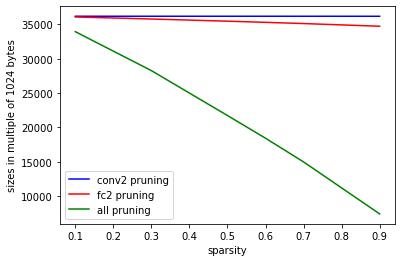

In [125]:
conv1_pruned_siz = []
fc2_pruned_siz = []
all_pruned_siz = []
for s in sparsity:
    PATH = f'pruned_conv1_{s}.zip'
    stats = os.stat(PATH)
    conv1_pruned_siz.append(stats.st_size/1024)
    PATH = f'pruned_fc2_{s}.zip'
    stats = os.stat(PATH)
    fc2_pruned_siz.append(stats.st_size/1024)
    PATH = f'pruned_all_{s}.zip'
    stats = os.stat(PATH)
    all_pruned_siz.append(stats.st_size/1024)
fig = plt.figure()
ax1 = fig.add_subplot(xlabel='sparsity', ylabel='sizes in multiple of 1024 bytes')
ax1.plot(sparsity, conv1_pruned_siz, c='b', label='conv2 pruning')
ax1.plot(sparsity, fc2_pruned_siz, c='r', label='fc2 pruning')
ax1.plot(sparsity, all_pruned_siz, c='g', label='all pruning')
plt.legend(loc='lower left');
plt.show()

And the original size of the NN without pruning is

In [130]:
PATH = './cifar_net_'+str(epochs)+'.pth'
with ZipFile(f'{PATH}.zip', 'w', compression=zipfile.ZIP_DEFLATED) as z:
        z.write(PATH)
PATH = f'{PATH}.zip'
print(f'Compressed size of the unpruned NN in multiple of 1024 bytes is {(os.stat(PATH).st_size/1024)}')

Compressed size of the unpruned NN in multiple of 1024 bytes is 36204.93359375


Pruned NN's sizes with different parts pruned to different extent

In [144]:
for i in range(len(sparsity)):
    print(f'Size of compressed conv1 {sparsity[i]*100}% sparsed network in multiple of 1024 bytes is {conv1_pruned_siz[i]}')
    print(f'Size of compressed fc2 {sparsity[i]*100}% sparsed network in multiple of 1024 bytes is {fc2_pruned_siz[i]}')
    print(f'Size of compressed all {sparsity[i]*100}% sparsed network in multiple of 1024 bytes is {all_pruned_siz[i]}')

Size of compressed conv1 10.0% sparsed network in multiple of 1024 bytes is 36199.15234375
Size of compressed fc2 10.0% sparsed network in multiple of 1024 bytes is 36092.18359375
Size of compressed all 10.0% sparsed network in multiple of 1024 bytes is 33953.4580078125
Size of compressed conv1 30.0% sparsed network in multiple of 1024 bytes is 36199.1533203125
Size of compressed fc2 30.0% sparsed network in multiple of 1024 bytes is 35797.5654296875
Size of compressed all 30.0% sparsed network in multiple of 1024 bytes is 28274.7353515625
Size of compressed conv1 50.0% sparsed network in multiple of 1024 bytes is 36199.15234375
Size of compressed fc2 50.0% sparsed network in multiple of 1024 bytes is 35478.5869140625
Size of compressed all 50.0% sparsed network in multiple of 1024 bytes is 21730.3271484375
Size of compressed conv1 60.0% sparsed network in multiple of 1024 bytes is 36199.169921875
Size of compressed fc2 60.0% sparsed network in multiple of 1024 bytes is 35310.825195312

So it can be seen that with increase in sparsity we see reduced model size, also for any amount of pruning we see that what is being pruned also matters and compression follows the order all > fc2 > conv1. It is expected when all the layers are pruned but interestingly fc2 gives greater compression than conv1 layer. Oh! it could be because conv1 does not have that much parameters to start with

In [146]:
import time

Let's check the effect of pruning on accuracy. But let's load the pruned models.

In [149]:
conv1_pruned_nets = []
fc2_pruned_nets = []
all_pruned_nets = []
for s in sparsity:
    net = CNN()
    PATH = f'./cifar_net_conv1p_{s}.pth'
    net.load_state_dict(torch.load(PATH))
    conv1_pruned_nets.append(net)
    net = CNN()
    PATH = f'./cifar_net_fc2p_{s}.pth'
    net.load_state_dict(torch.load(PATH))
    fc2_pruned_nets.append(net)
    net = CNN()
    PATH = f'./cifar_net_allp_{s}.pth'
    net.load_state_dict(torch.load(PATH))
    all_pruned_nets.append(net)

In [157]:
conv1_pruned_accr = []
fc2_pruned_accr = []
all_pruned_accr = []
conv1_pruned_t = []
fc2_pruned_t = []
all_pruned_t = []

for i in range(len(sparsity)):
    print(f'Calculating accuracy for Sparsity {sparsity[i]}')
    cnv1_correct = 0
    cnv1_total = 0
    fc2_correct = 0
    fc2_total = 0
    all_correct = 0
    all_total = 0
    conv1_t_tot = 0
    fc2_t_tot = 0
    all_t_tot = 0
    with torch.no_grad():
        for data in test_loader:
            inputs, labels = data[0].to(device), data[1].to(device)
            
            start = time.time()
            outputs = conv1_pruned_nets[i](inputs)
            conv1_t_tot += (time.time() - start)
            _, predicted = torch.max(outputs.data, 1)
            cnv1_total += labels.size(0)
            cnv1_correct += (predicted == labels).sum().item()
            
            start = time.time()
            outputs = fc2_pruned_nets[i](inputs)
            fc2_t_tot += (time.time() - start)
            _, predicted = torch.max(outputs.data, 1)
            fc2_total += labels.size(0)
            fc2_correct += (predicted == labels).sum().item()
            
            start = time.time()
            outputs = all_pruned_nets[i](inputs)
            all_t_tot += (time.time() - start)
            _, predicted = torch.max(outputs.data, 1)
            all_total += labels.size(0)
            all_correct += (predicted == labels).sum().item()

    conv1_pruned_accr.append(100 * cnv1_correct / cnv1_total)
    fc2_pruned_accr.append(100 * fc2_correct / fc2_total)
    all_pruned_accr.append(100 * all_correct / all_total)
    conv1_pruned_t.append(conv1_t_tot)
    fc2_pruned_t.append(fc2_t_tot)
    all_pruned_t.append(all_t_tot)

Calculating accuracy for Sparsity 0.1
Calculating accuracy for Sparsity 0.3
Calculating accuracy for Sparsity 0.5
Calculating accuracy for Sparsity 0.6
Calculating accuracy for Sparsity 0.7
Calculating accuracy for Sparsity 0.9


Let's check the effect on the accuracy

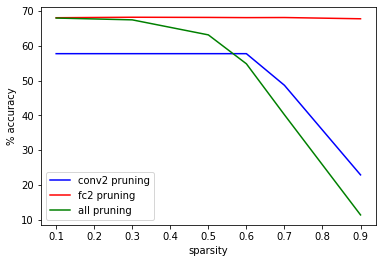

In [161]:
fig = plt.figure()
ax1 = fig.add_subplot(xlabel='sparsity', ylabel='% accuracy')
ax1.plot(sparsity, conv1_pruned_accr, c='b', label='conv2 pruning')
ax1.plot(sparsity, fc2_pruned_accr, c='r', label='fc2 pruning')
ax1.plot(sparsity, all_pruned_accr, c='g', label='all pruning')
plt.legend(loc='lower left');
plt.show()

In [164]:
print(conv1_pruned_accr)
print(fc2_pruned_accr)
print(all_pruned_accr)

[57.74, 57.74, 57.74, 57.74, 48.65, 22.9]
[68.07, 68.21, 68.16, 68.1, 68.13, 67.77]
[67.98, 67.46, 63.14, 54.83, 40.17, 11.39]


So accuracy decreases with increase in sparsity which is expected. But interestingly, for the amount of compression achieved by fc2 pruning, there is not much loss in the accuracy. Where as, conv1 does least compression with increase in sparsity, but still accuracy is least.

Let's check the effect on performance.I have assumed prediction time as performance. 

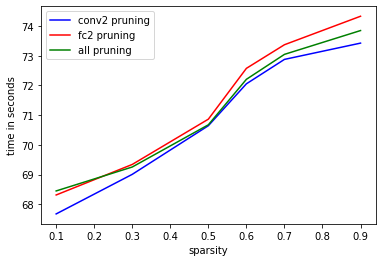

In [166]:
fig = plt.figure()
ax1 = fig.add_subplot(xlabel='sparsity', ylabel='time in seconds')
ax1.plot(sparsity, conv1_pruned_t, c='b', label='conv2 pruning')
ax1.plot(sparsity, fc2_pruned_t, c='r', label='fc2 pruning')
ax1.plot(sparsity, all_pruned_t, c='g', label='all pruning')
plt.legend(loc='upper left');
plt.show()

Actually, I think it would make more sense to check the performance if it would have been structured pruning, as it gurantees removal of some type of parts of NN as compared to unstructured pruning which zeroes out the weights mostly.